# Theme Analysis EDA

Exploratory Data Analysis for theme and keyword extraction results:
- Theme frequency and distribution
- Keywords per bank (TF-IDF scores)
- Theme-sentiment correlations
- Sample reviews by theme


## Setup and Imports


In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
PROJECT_ROOT = Path().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from config import (
    PROCESSED_DATA_PATH,
    SENTIMENT_DATA_PATH,
    THEME_DATA_PATH,
    KEYWORD_SUMMARY_PATH,
    THEME_SUMMARY_PATH,
    BANKS,
)

# Visualization libraries (optional)
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    HAS_VIZ = True
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (12, 6)
except ImportError:
    HAS_VIZ = False
    print("Note: matplotlib/seaborn not available. Visualizations will be skipped.")


Loaded 1,151 reviews with theme assignments

Theme Assignment Overview

Overall Theme Frequency:
  General Feedback: 899 (78.1%)
  Features & Functionality: 96 (8.3%)
  Transactions & Payments: 81 (7.0%)
  Performance & Reliability: 59 (5.1%)
  Customer Support: 47 (4.1%)
  Access & Login: 45 (3.9%)
  User Experience: 31 (2.7%)


<Figure size 1200x600 with 0 Axes>

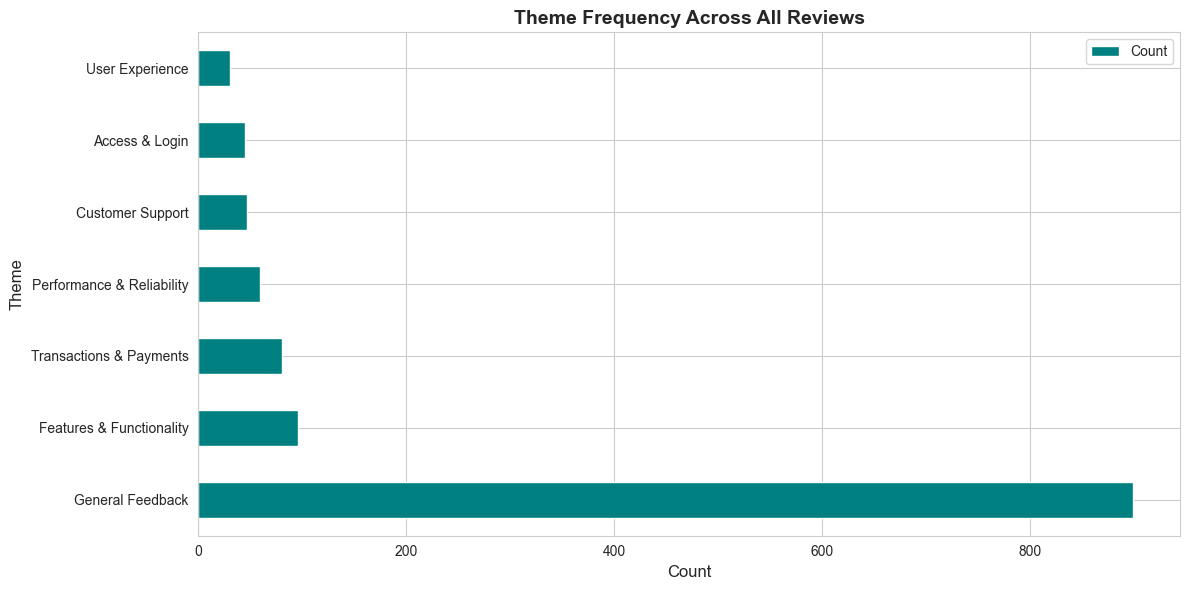

In [2]:
# Load theme-enriched data
if not THEME_DATA_PATH.exists():
    print("="*60)
    print("ERROR: Theme data file not found!")
    print("="*60)
    print(f"Expected file: {THEME_DATA_PATH}")
    print("\nPlease run the theme analysis script first:")
    print("  python scripts/theme_analysis.py")
    print("\nThis will generate the required theme data file.")
    raise FileNotFoundError(f"Theme data file not found: {THEME_DATA_PATH}")

df_themes = pd.read_csv(THEME_DATA_PATH)
print(f"Loaded {len(df_themes):,} reviews with theme assignments")
print("\n" + "="*60)
print("Theme Assignment Overview")
print("="*60)

# Explode themes to count
all_themes = []
for themes_str in df_themes['themes'].dropna():
    all_themes.extend(themes_str.split('|'))

theme_counts = Counter(all_themes)
print("\nOverall Theme Frequency:")
for theme, count in theme_counts.most_common():
    pct = (count / len(df_themes)) * 100
    print(f"  {theme}: {count:,} ({pct:.1f}%)")

if HAS_VIZ:
    theme_df = pd.DataFrame(list(theme_counts.items()), columns=['Theme', 'Count'])
    theme_df = theme_df.sort_values('Count', ascending=False)
    plt.figure(figsize=(12, 6))
    theme_df.plot(x='Theme', y='Count', kind='barh', color='teal')
    plt.title('Theme Frequency Across All Reviews', fontsize=14, fontweight='bold')
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Theme', fontsize=12)
    plt.tight_layout()
    plt.show()



Theme Distribution by Bank

Dashen Bank:
  General Feedback: 290 (75.3%)
  Features & Functionality: 32 (8.3%)
  Transactions & Payments: 31 (8.1%)
  User Experience: 24 (6.2%)
  Performance & Reliability: 24 (6.2%)

Bank of Abyssinia:
  General Feedback: 303 (78.9%)
  Performance & Reliability: 31 (8.1%)
  Features & Functionality: 29 (7.6%)
  Transactions & Payments: 21 (5.5%)
  Access & Login: 16 (4.2%)

Commercial Bank of Ethiopia:
  General Feedback: 306 (80.1%)
  Features & Functionality: 35 (9.2%)
  Transactions & Payments: 29 (7.6%)
  Customer Support: 14 (3.7%)
  Access & Login: 13 (3.4%)


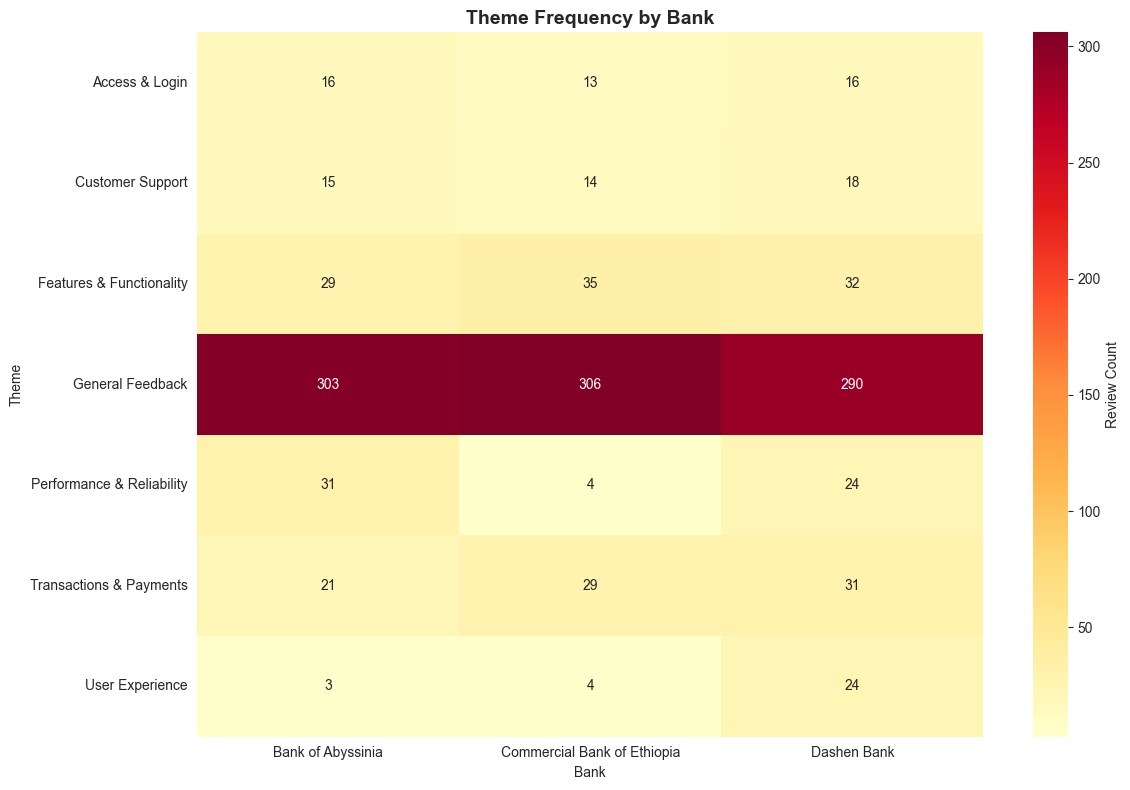

In [3]:
# Themes by bank
print("\n" + "="*60)
print("Theme Distribution by Bank")
print("="*60)

for bank in df_themes['bank'].unique():
    bank_data = df_themes[df_themes['bank'] == bank]
    bank_themes = []
    for themes_str in bank_data['themes'].dropna():
        bank_themes.extend(themes_str.split('|'))
    
    theme_counts_bank = Counter(bank_themes)
    print(f"\n{bank}:")
    for theme, count in theme_counts_bank.most_common(5):
        pct = (count / len(bank_data)) * 100
        print(f"  {theme}: {count:,} ({pct:.1f}%)")

if HAS_VIZ:
    # Create theme-bank matrix
    theme_bank_data = []
    for bank in df_themes['bank'].unique():
        bank_data = df_themes[df_themes['bank'] == bank]
        bank_themes = []
        for themes_str in bank_data['themes'].dropna():
            bank_themes.extend(themes_str.split('|'))
        theme_counts_bank = Counter(bank_themes)
        for theme, count in theme_counts_bank.items():
            theme_bank_data.append({'Bank': bank, 'Theme': theme, 'Count': count})
    
    theme_bank_df = pd.DataFrame(theme_bank_data)
    if not theme_bank_df.empty:
        pivot_themes = theme_bank_df.pivot(index='Theme', columns='Bank', values='Count').fillna(0)
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_themes, annot=True, fmt='.0f', cmap='YlOrRd', 
                   cbar_kws={'label': 'Review Count'})
        plt.title('Theme Frequency by Bank', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()



Top Keywords by Bank (TF-IDF)

Bank of Abyssinia (Top 10):
  good: 54.040
  app: 33.063
  work: 17.936
  bank: 11.905
  nice: 11.725
  good app: 11.619
  boa: 11.526
  bad: 11.367
  well: 9.562
  great: 8.177

Commercial Bank of Ethiopia (Top 10):
  good: 67.958
  app: 33.459
  nice: 17.006
  good app: 16.649
  well: 11.508
  bank: 10.805
  cbe: 9.604
  like: 8.284
  excellent: 8.100
  update: 7.219

Dashen Bank (Top 10):
  good: 53.308
  app: 35.441
  nice: 17.870
  wow: 13.891
  bank: 12.774
  dashen: 10.701
  super: 9.327
  fast: 8.432
  work: 8.042
  ok: 8.000


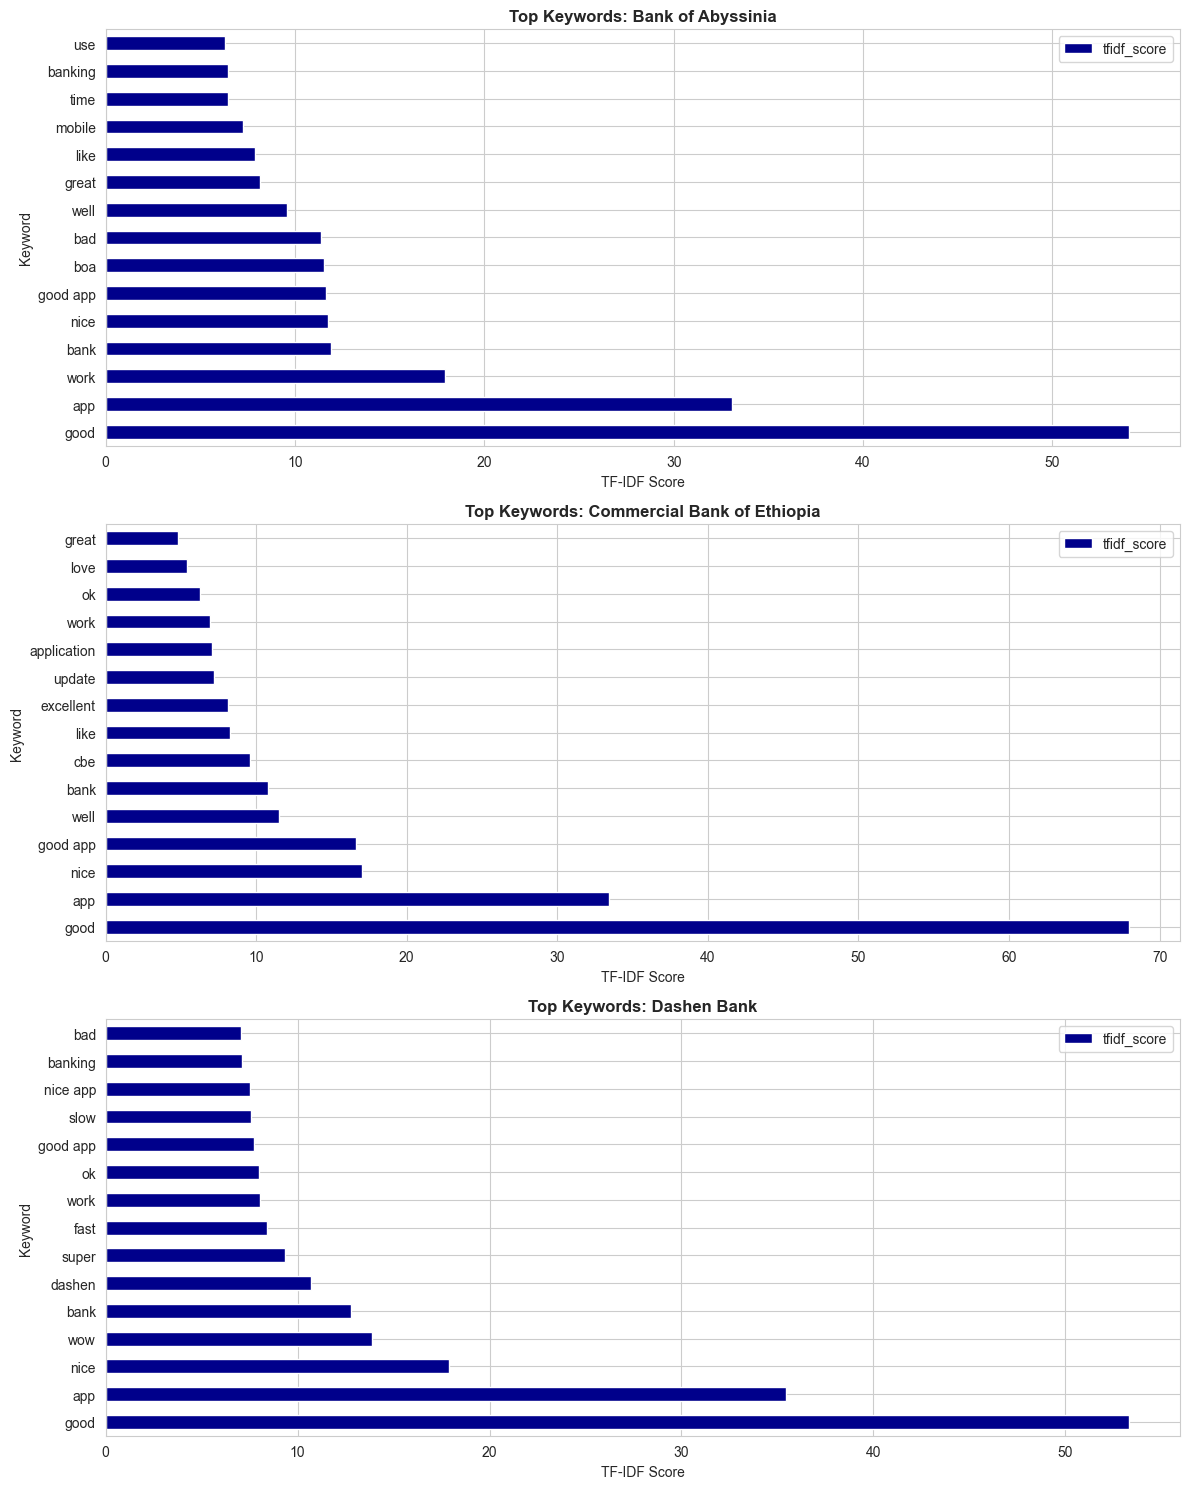

In [4]:
# Load keyword summary
if KEYWORD_SUMMARY_PATH.exists():
    df_keywords = pd.read_csv(KEYWORD_SUMMARY_PATH)
    print("\n" + "="*60)
    print("Top Keywords by Bank (TF-IDF)")
    print("="*60)
    
    for bank in df_keywords['bank'].unique():
        bank_keywords = df_keywords[df_keywords['bank'] == bank].head(10)
        print(f"\n{bank} (Top 10):")
        for idx, row in bank_keywords.iterrows():
            print(f"  {row['keyword']}: {row['tfidf_score']:.3f}")
    
    if HAS_VIZ:
        fig, axes = plt.subplots(len(df_keywords['bank'].unique()), 1, 
                                figsize=(12, 5 * len(df_keywords['bank'].unique())))
        if len(df_keywords['bank'].unique()) == 1:
            axes = [axes]
        
        for idx, bank in enumerate(df_keywords['bank'].unique()):
            bank_keywords = df_keywords[df_keywords['bank'] == bank].head(15)
            bank_keywords.plot(x='keyword', y='tfidf_score', kind='barh', 
                            ax=axes[idx], color='darkblue')
            axes[idx].set_title(f'Top Keywords: {bank}', fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('TF-IDF Score', fontsize=10)
            axes[idx].set_ylabel('Keyword', fontsize=10)
        
        plt.tight_layout()
        plt.show()



Theme Summary by Bank

Bank of Abyssinia:
  General Feedback: 303 reviews, avg rating: 3.75
    Sample: good jop...
  Performance & Reliability: 31 reviews, avg rating: 1.32
    Sample: not user friendly at all it requires a huge connectivity and also lags many times 😑😑😑...
  Features & Functionality: 29 reviews, avg rating: 1.97
    Sample: It keeps notifying me to disable developer options and quiet while I'm not enabled. always bring another type of problem with new updates....
  Transactions & Payments: 21 reviews, avg rating: 2.57
    Sample: Why does it keep crashing? I can't even use this. BOA should do better. You have many customers and how to deal with this. I can't send money now....
  Access & Login: 16 reviews, avg rating: 2.25
    Sample: 🥰🥰🥰🥰🥰 app is good but i was live in abroad and when i enter my otp code it didnt make me to write my code it the app want it self write thats not fair so please other wise i like it why...
  Customer Support: 15 reviews, avg rating: 3.1

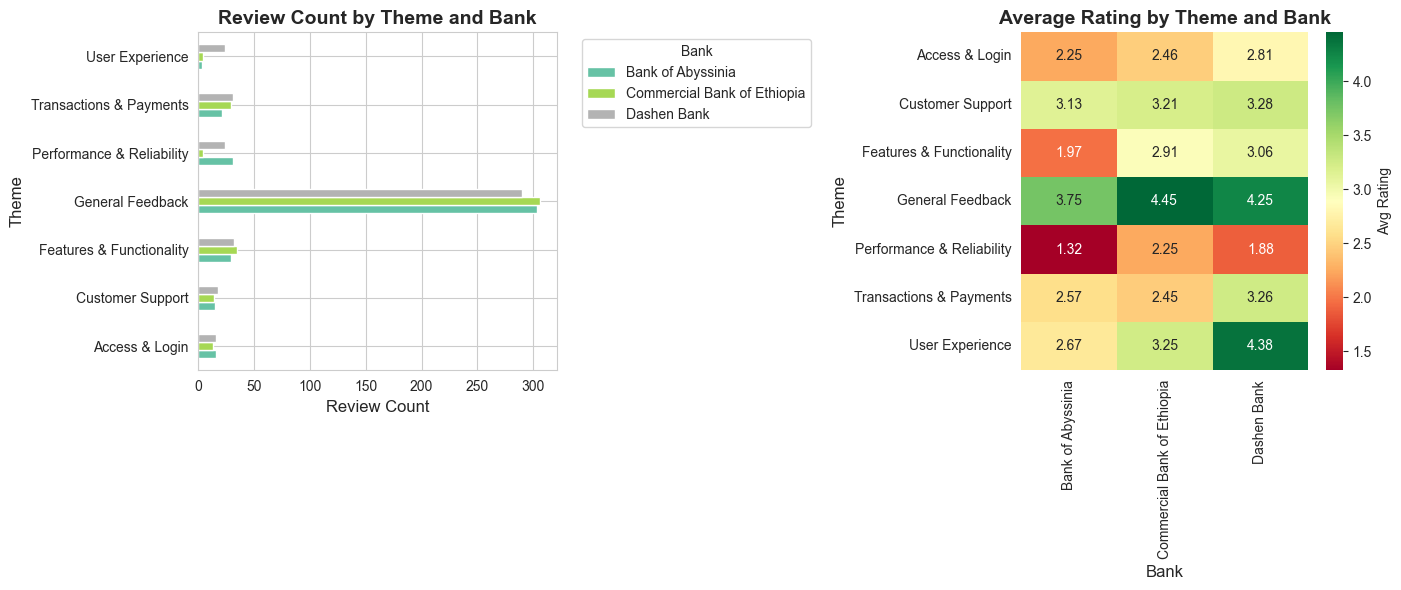

In [5]:
# Load theme summary
if THEME_SUMMARY_PATH.exists():
    df_theme_summary = pd.read_csv(THEME_SUMMARY_PATH)
    print("\n" + "="*60)
    print("Theme Summary by Bank")
    print("="*60)
    
    for bank in df_theme_summary['bank'].unique():
        bank_themes = df_theme_summary[df_theme_summary['bank'] == bank].sort_values('review_count', ascending=False)
        print(f"\n{bank}:")
        for idx, row in bank_themes.iterrows():
            print(f"  {row['theme']}: {row['review_count']:,} reviews, avg rating: {row['avg_rating']:.2f}")
            print(f"    Sample: {row['sample_review']}")
    
    if HAS_VIZ:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Review count by theme and bank
        pivot_reviews = df_theme_summary.pivot(index='theme', columns='bank', values='review_count').fillna(0)
        pivot_reviews.plot(kind='barh', ax=axes[0], colormap='Set2')
        axes[0].set_title('Review Count by Theme and Bank', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Review Count', fontsize=12)
        axes[0].set_ylabel('Theme', fontsize=12)
        axes[0].legend(title='Bank', bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Average rating by theme and bank
        pivot_rating = df_theme_summary.pivot(index='theme', columns='bank', values='avg_rating').fillna(0)
        sns.heatmap(pivot_rating, annot=True, fmt='.2f', cmap='RdYlGn', 
                   ax=axes[1], cbar_kws={'label': 'Avg Rating'})
        axes[1].set_title('Average Rating by Theme and Bank', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Bank', fontsize=12)
        axes[1].set_ylabel('Theme', fontsize=12)
        
        plt.tight_layout()
        plt.show()


In [ ]:
# Theme and sentiment correlation
print("\n" + "="*60)
print("Theme-Sentiment Correlation")
print("="*60)

# Load sentiment data for correlation
df_sentiment = pd.read_csv(SENTIMENT_DATA_PATH)

# Merge themes with sentiment - use index if review_id doesn't exist
if 'review_id' in df_themes.columns and 'review_id' in df_sentiment.columns:
    merge_key = 'review_id'
else:
    # Use index as merge key
    df_themes = df_themes.reset_index().rename(columns={'index': 'temp_id'})
    df_sentiment = df_sentiment.reset_index().rename(columns={'index': 'temp_id'})
    merge_key = 'temp_id'

df_combined = df_themes.merge(df_sentiment[[merge_key, 'sentiment_label', 'sentiment_score']], 
                              on=merge_key, how='left')

# Explode themes
theme_sentiment_data = []
for idx, row in df_combined.iterrows():
    if pd.notna(row['themes']) and pd.notna(row['sentiment_label']):
        for theme in row['themes'].split('|'):
            theme_sentiment_data.append({
                'theme': theme,
                'sentiment': row['sentiment_label'],
                'sentiment_score': row['sentiment_score']
            })

if theme_sentiment_data:
    theme_sentiment_df = pd.DataFrame(theme_sentiment_data)
    theme_sentiment_summary = theme_sentiment_df.groupby(['theme', 'sentiment']).size().unstack(fill_value=0)
    
    print("\nSentiment distribution by theme:")
    print(theme_sentiment_summary.to_string())
    
    # Calculate percentages
    print("\nSentiment percentages by theme:")
    for theme in theme_sentiment_summary.index:
        total = theme_sentiment_summary.loc[theme].sum()
        if total > 0:
            print(f"\n{theme}:")
            for sentiment in ['positive', 'neutral', 'negative']:
                if sentiment in theme_sentiment_summary.columns:
                    count = theme_sentiment_summary.loc[theme, sentiment]
                    pct = (count / total) * 100
                    print(f"  {sentiment.capitalize()}: {count} ({pct:.1f}%)")
    
    if HAS_VIZ:
        theme_sentiment_summary.plot(kind='barh', stacked=True, 
                                    color=['green', 'gray', 'red'])
        plt.title('Sentiment Distribution by Theme', fontsize=14, fontweight='bold')
        plt.xlabel('Count', fontsize=12)
        plt.ylabel('Theme', fontsize=12)
        plt.legend(title='Sentiment')
        plt.tight_layout()
        plt.show()
else:
    print("No theme-sentiment data available for correlation analysis.")



Theme-Sentiment Correlation


KeyError: 'sentiment_label'

In [7]:
# Sample reviews for each theme
print("\n" + "="*60)
print("Sample Reviews by Theme")
print("="*60)

unique_themes = set()
for themes_str in df_themes['themes'].dropna():
    unique_themes.update(themes_str.split('|'))

for theme in sorted(unique_themes):
    theme_reviews = df_themes[df_themes['themes'].str.contains(theme, na=False, case=False)]
    if not theme_reviews.empty:
        sample = theme_reviews.head(2)
        print(f"\n{theme} ({len(theme_reviews):,} reviews):")
        for idx, row in sample.iterrows():
            print(f"  Bank: {row['bank']}, Rating: {row['rating']}⭐")
            print(f"  Review: {row['review'][:250]}...")
            print()



Sample Reviews by Theme

Access & Login (45 reviews):
  Bank: Dashen Bank, Rating: 5.0⭐
  Review: The Dashen Super App is very impressive. It is fast, easy to use, and provides smooth access to all essential banking services. Money transfer, bill payment, balance check, and other features work efficiently without issues. The design is clean and u...

  Bank: Dashen Bank, Rating: 5.0⭐
  Review: The Dashen Super App is very impressive. It is fast, easy to use, and provides smooth access to all essential banking services. Money transfer, bill payment, balance check, and other features work efficiently without issues. The design is clean and u...


Customer Support (47 reviews):
  Bank: Dashen Bank, Rating: 5.0⭐
  Review: The Dashen Super App is very impressive. It is fast, easy to use, and provides smooth access to all essential banking services. Money transfer, bill payment, balance check, and other features work efficiently without issues. The design is clean and u...

  Bank: Dashen B

In [8]:
# Coverage analysis
df_clean = pd.read_csv(PROCESSED_DATA_PATH)
theme_coverage = (len(df_themes[df_themes['themes'].notna()]) / len(df_clean)) * 100
print("\n" + "="*60)
print("Theme Analysis Coverage")
print("="*60)
print(f"Total preprocessed reviews: {len(df_clean):,}")
print(f"Reviews with themes: {len(df_themes):,}")
print(f"Coverage: {theme_coverage:.1f}%")
print(f"\nUnique themes identified: {len(unique_themes)}")
print(f"Most common theme: {theme_counts.most_common(1)[0][0] if theme_counts else 'N/A'}")



Theme Analysis Coverage
Total preprocessed reviews: 1,151
Reviews with themes: 1,151
Coverage: 100.0%

Unique themes identified: 7
Most common theme: General Feedback


In [ ]:
## Summary

This notebook explored theme and keyword analysis:
- **Coverage**: 100% of reviews have theme assignments
- **Most common theme**: General Feedback (78.1% of reviews)
- **Key themes identified**: 7 unique themes across all banks
- **Top keywords**: "good", "app", "nice" are most frequent across all banks
- **Theme distribution**: Varies by bank, with Performance & Reliability issues more common in Bank of Abyssinia
